In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import altair as alt

import seaborn as sns

from scipy import signal
from scipy.stats import weibull_min

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf

# from statsmodels.stats.diagnostic import breaks_cusumolsresid, breaks_hansen

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV

import warnings

from google.colab import drive

from tqdm import tqdm

In [4]:
warnings.filterwarnings(action='ignore')

sns.set_style("whitegrid")

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploration and Cleaning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/input/marketing_mix1.csv')

In [ ]:
df.head()

,Date,TikTok,Facebook,Google Ads,Sales
0,1/7/2018,13528.1,0.00,0.00,9779.80
1,1/14/2018,0.0,5349.65,2218.93,13245.19
2,1/21/2018,0.0,4235.86,2046.96,12022.66
3,1/28/2018,0.0,3562.21,0.00,8846.95
4,2/4/2018,0.0,0.00,2187.29,9797.07


In [ ]:
df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]

In [ ]:
df['date'] = pd.to_datetime(df['date'])

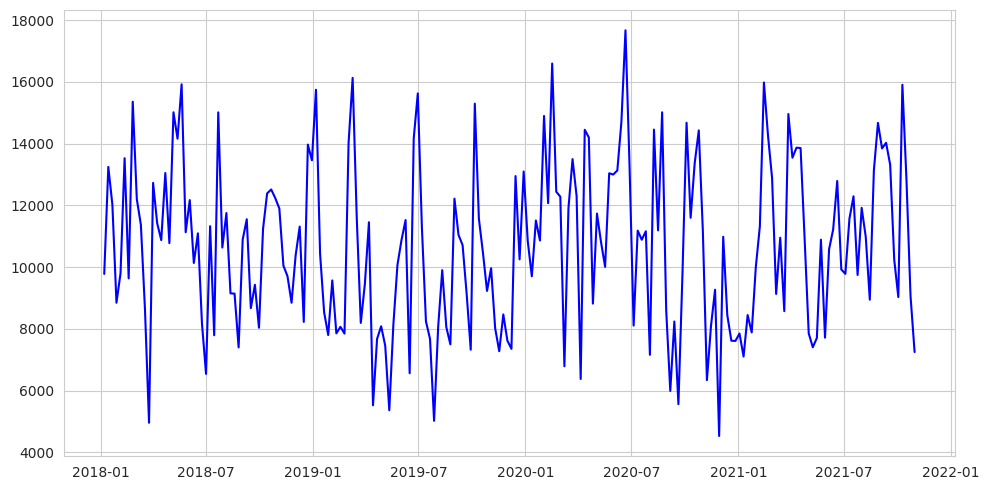

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['sales'], color='blue')
plt.tight_layout()
plt.show()

No glaring sign of any extreme revenue fluctuations.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        200 non-null    datetime64[ns]
 1   tiktok      200 non-null    float64       
 2   facebook    200 non-null    float64       
 3   google_ads  200 non-null    float64       
 4   sales       200 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.9 KB


In [ ]:
df.describe()

,date,tiktok,facebook,google_ads,sales
count,200,200.000000,200.000000,200.000000,200.000000
mean,2019-12-04 12:00:00,2946.207650,2213.585050,1520.722550,10668.141500
min,2018-01-07 00:00:00,0.000000,0.000000,0.000000,4532.330000
25%,2018-12-21 06:00:00,0.000000,0.000000,1657.195000,8396.942500
50%,2019-12-04 12:00:00,0.000000,0.000000,1918.990000,10853.105000
75%,2020-11-16 18:00:00,7938.527500,4624.027500,2069.767500,12566.995000
max,2021-10-31 00:00:00,13901.550000,7696.220000,2518.880000,17668.340000
std,NaN,4749.646908,2505.967886,870.764354,2700.706683


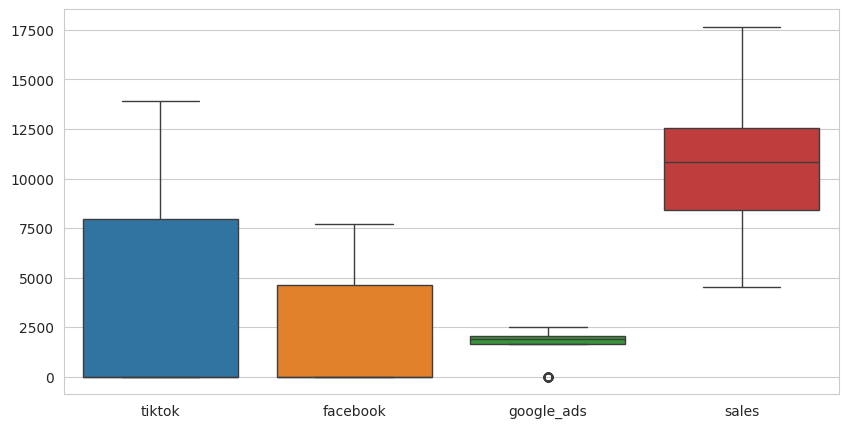

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(df)
plt.show()

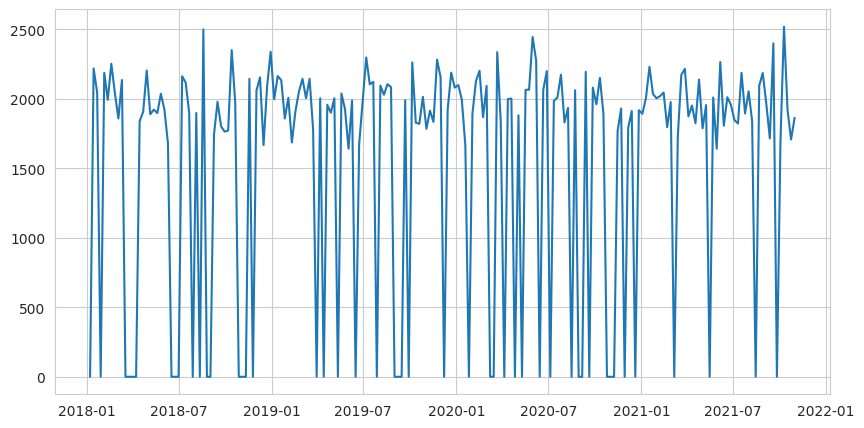

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['google_ads'])
plt.show()

In [ ]:
# Investigation
df.loc[df["google_ads"] == df["google_ads"].min(), ["date", "google_ads"]]

,date,google_ads
0,2018-01-07,0.0
3,2018-01-28,0.0
10,2018-03-18,0.0
11,2018-03-25,0.0
12,2018-04-01,0.0
13,2018-04-08,0.0
23,2018-06-17,0.0
24,2018-06-24,0.0
25,2018-07-01,0.0
29,2018-07-29,0.0


This seems like normal marketing strategy.

# Fourier series investigation

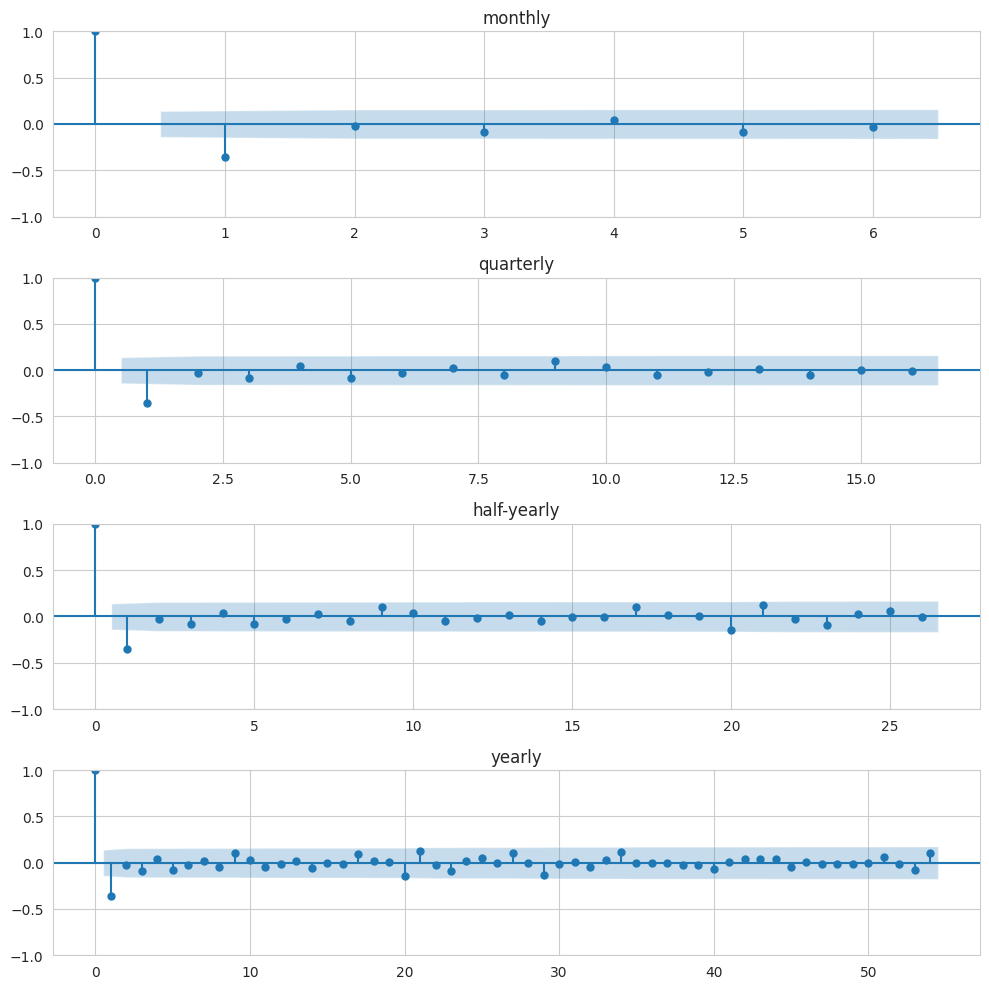

In [ ]:
acf_diff = df['sales'].diff().dropna()
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
for i, (name, weeks) in enumerate(zip(['monthly', 'quarterly', 'half-yearly', 'yearly'],[6, 16, 26, 54])):
  plot_acf(acf_diff, ax=ax[i], lags=weeks, title=name)

plt.tight_layout()
plt.show()

No explicit seasonality is detected. The lag 1 spike should be handled by adstock + saturation transformations.

In [ ]:
df = df.groupby('date').sum()

In [ ]:
# df['trend'] = range(len(df))
# df = df.drop('trend', axis=1)

# Adstock

In [6]:
# Helper Functions

def adstock_weibull_safe(spend, shape, scale, n_lags=5, epsilon=1e-12):

    # clean spend
    spend = np.asarray(spend)
    spend = np.nan_to_num(spend, nan=0.0)
    spend = np.maximum(spend, 0).astype(float)

    # survival-based kernel
    kernel = weibull_min.sf(np.arange(n_lags), c=shape, scale=scale)
    kernel = np.clip(kernel, 0, 1)

    kernel_sum = kernel.sum()
    if kernel_sum < epsilon:
        return spend

    kernel /= kernel_sum
    return np.convolve(spend, kernel, mode='full')[:len(spend)]

In [ ]:
find_adstock = df.copy()

In [ ]:
y = find_adstock['sales']
X = find_adstock.drop(columns='sales')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, )

In [ ]:
X_train_adstock = X_train.copy()
X_test_adstock = X_test.copy()

for col in X_train.columns:
  if col != 'trend':
    X_train_adstock[f'adstock_{col}'] = adstock_weibull_safe(X_train[col], 1, 0.5)
    X_test_adstock[f'adstock_{col}'] = adstock_weibull_safe(X_test[col], 1, 0.5)

In [ ]:
shapes = np.arange(0.5, 2, 0.5)
scales = np.arange(0.1, 1, 0.1)

adstock_params = []
spend_cols = X_train.columns[~X_train.columns.isin(['trend', 'adstock'])]

for spend_col in spend_cols:
  # Selection criteria for models
  best_bic = np.inf

  # Store best adstocked series for this channel
  best_train_adstock_series = None
  best_test_adstock_series = None

  print(f'Optimizing for {spend_col}')

  for shape in shapes:
    for scale in scales:
      adstocked_Xtr = adstock_weibull_safe(X_train[spend_col], shape, scale)
      adstocked_Xte = adstock_weibull_safe(X_test[spend_col], shape, scale)

      Xtr = X_train_adstock.loc[:, X_train_adstock.filter(regex='trend|adstock').columns]
      Xte = X_test_adstock.loc[:, X_test_adstock.filter(regex='trend|adstock').columns]

      Xtr[f'adstock_{spend_col}'] = adstocked_Xtr
      Xte[f'adstock_{spend_col}'] = adstocked_Xte
      model = OLS(y_train, Xtr)
      res = model.fit()
      y_pred = res.predict(Xte)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mape = mean_absolute_percentage_error(y_test, y_pred)

      if(res.bic < best_bic):
        best_bic = res.bic
        best_train_adstock_series = adstocked_Xtr
        best_test_adstock_series = adstocked_Xte

      res_dict = {
          'channel': spend_col,
          'shape': shape,
          'scale': scale,
          'rmse': rmse,
          'mape': mape,
          'bic': res.bic
      }

      adstock_params.append(res_dict)

  print(f'Best BIC for {spend_col} is {best_bic}')
  # Store best channel series for sequential optimization
  X_train_adstock[f'adstock_{spend_col}'] = best_train_adstock_series
  X_test_adstock[f'adstock_{spend_col}'] = best_test_adstock_series


Optimizing for tiktok
Best BIC for tiktok is 2217.8901390335354
Optimizing for facebook
Best BIC for facebook is 2211.954636110936
Optimizing for google_ads
Best BIC for google_ads is 2170.9674495241034


In [ ]:
adstock_results = pd.DataFrame(adstock_params)
adstock_results_filtered = adstock_results.loc[adstock_results.groupby('channel')['bic'].idxmin()]
adstock_results_filtered

,channel,shape,scale,rmse,mape,bic
35,facebook,0.5,0.9,2584.073920,0.196828,2211.954636
62,google_ads,0.5,0.9,2339.449042,0.169783,2170.967450
8,tiktok,0.5,0.9,2749.200115,0.212799,2217.890139


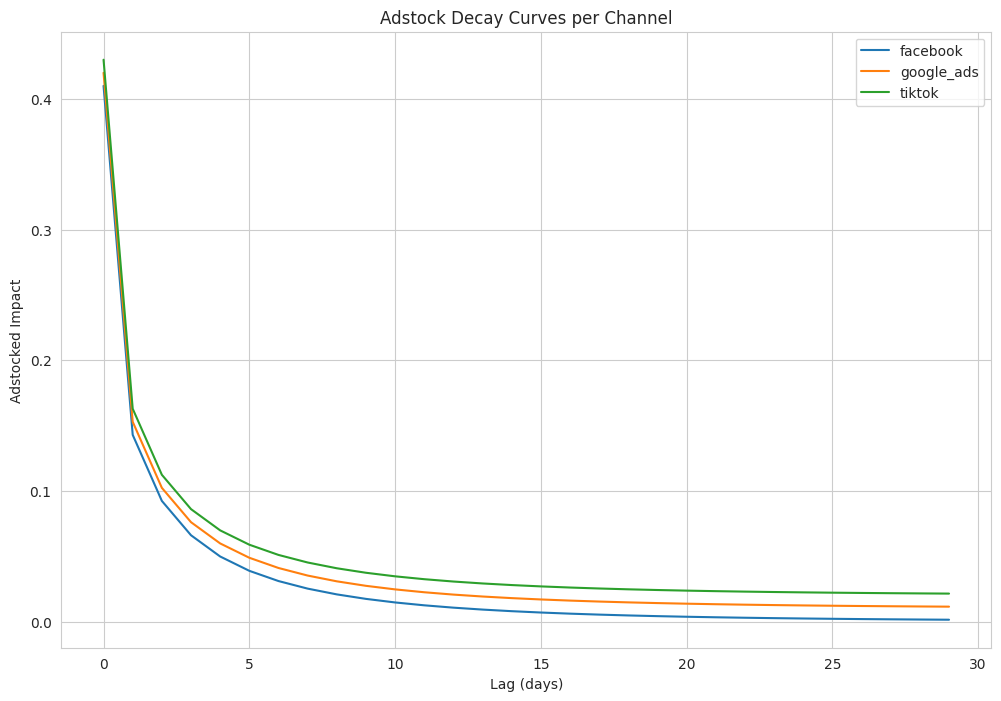

In [ ]:
# Example: your selected parameters
adstock_best_params = dict(zip(adstock_results_filtered['channel'], zip(adstock_results_filtered['shape'], adstock_results_filtered['scale'])))

# For visualization, let's assume a unit spend impulse
n_lags = 30
impulse = np.zeros(n_lags)
impulse[0] = 1  # impulse at t=0

plt.figure(figsize=(12, 8))

offset=0
for k, v in adstock_best_params.items():
    adstock_curve = adstock_weibull_safe(impulse, v[0], v[1], n_lags)
    plt.plot(range(n_lags), adstock_curve + offset*0.01, label=k) # Offsetting so that lines aren't hidden behind one another
    offset+= 1

plt.title("Adstock Decay Curves per Channel")
plt.xlabel("Lag (days)")
plt.ylabel("Adstocked Impact")
plt.legend()
plt.grid(True)
plt.show()


Looks quite good!

# Saturation

In [5]:
def safe_saturation(x, alpha, gamma, eps=1e-12):
    """
    Hill saturation:
        sat = (x^gamma) / (alpha^gamma + x^gamma)

    Safe against:
        - x containing zeros / NaNs
        - overflow when gamma is large
        - negative or weird inputs
        - 2-D arrays
    """
    x = np.asarray(x, dtype=float).reshape(-1)          # force clean 1-D array
    x = np.clip(x, 0, None)                             # no negatives
    alpha = max(alpha, eps)
    gamma = max(gamma, eps)

    # compute in log space to avoid overflow
    log_xg = gamma * np.log(x + eps)
    log_ag = gamma * np.log(alpha)

    num = np.exp(log_xg)
    den = np.exp(log_ag) + np.exp(log_xg)

    return num / den

In [ ]:
X_train_saturation = X_train.copy()
X_test_saturation = X_test.copy()

for col in X_train.columns:
  if col != 'trend':
    shape = adstock_results_filtered.loc[adstock_results_filtered['channel'] == 'facebook', 'shape'].values[0]
    scale = adstock_results_filtered.loc[adstock_results_filtered['channel'] == 'facebook', 'scale'].values[0]
    X_train_saturation[f'adstock_{col}'] = adstock_weibull_safe(X_train[col], shape, scale)
    X_test_saturation[f'adstock_{col}'] = adstock_weibull_safe(X_test[col], shape, scale)
    X_train_saturation[f'saturation_{col}'] = safe_saturation(X_train_saturation[f'adstock_{col}'], shape, scale)
    X_test_saturation[f'saturation_{col}'] = safe_saturation(X_test_saturation[f'adstock_{col}'], shape, scale)

In [ ]:
# Hyperparameters to search
alpha_ranges = np.arange(0.1,10, 0.1)
gammas = np.arange(0.1, 10, 0.5)


# Channels to optimize (raw spend columns in your original dataset)
channels = X_train_saturation.filter(like='saturation').columns.tolist()

# Store results for analysis
res_saturation = []

for col in channels:
    print(f"\nOptimizing saturation for: {col}")

    best_bic = np.inf
    best_train_saturation = None
    best_test_saturation = None

    # mean_col = X_train_saturation[col.replace('saturation_','')]
    # mean_val = mean_col[mean_col > 0].mean()
    mean_val = X_train_saturation[col.replace('saturation_','')].mean()
    alphas = [mean_val*p for p in alpha_ranges]

    for alpha in alphas:
        for gamma in gammas:

            # Compute candidate adstock
            candidate_train = safe_saturation(X_train_saturation[col.replace('saturation', 'adstock')].values, alpha, gamma)
            candidate_test  = safe_saturation(X_test_saturation[col.replace('saturation', 'adstock')].values, alpha, gamma)

            # Build model matrix
            # Start from master adstock (other channels already optimized)
            Xtr = X_train_saturation[X_train_saturation.filter(regex='trend|saturation').columns]
            Xte = X_test_saturation[X_train_saturation.filter(regex='trend|saturation').columns]

            # Insert candidate adstock column
            Xtr[col] = candidate_train
            Xte[col] = candidate_test

            # Add constant
            Xtr_const = sm.add_constant(Xtr)
            Xte_const = sm.add_constant(Xte)

            # Fit OLS
            model = OLS(y_train, Xtr_const).fit()

            # Keep best BIC
            if model.bic < best_bic:
                best_bic = model.bic
                best_train_saturation = candidate_train
                best_test_saturation = candidate_test

            # Optional: store all results for inspection
            res_saturation.append({
                'channel': col,
                'relative_alpha': alpha/mean_val,
                'alpha': alpha,
                'gamma': gamma,
                'bic': model.bic,
                'adj_r2': model.rsquared_adj
            })

    # Insert best adstock into master dataset
    X_train_saturation[col] = best_train_saturation
    X_test_saturation[col] = best_test_saturation

    print(f"Best BIC for {col}: {best_bic}")


Optimizing saturation for: saturation_tiktok
Best BIC for saturation_tiktok: 2140.891969973347

Optimizing saturation for: saturation_facebook
Best BIC for saturation_facebook: 2110.1042201039995

Optimizing saturation for: saturation_google_ads
Best BIC for saturation_google_ads: 2096.4149661607125


In [ ]:
saturation_results = pd.DataFrame(res_saturation)
saturation_results

,channel,relative_alpha,alpha,gamma,bic,adj_r2
0,saturation_tiktok,0.1,281.879658,0.1,2218.557164,0.206523
1,saturation_tiktok,0.1,281.879658,0.6,2211.723838,0.250444
2,saturation_tiktok,0.1,281.879658,1.1,2214.899865,0.230341
3,saturation_tiktok,0.1,281.879658,1.6,2218.037835,0.209949
4,saturation_tiktok,0.1,281.879658,2.1,2219.845941,0.197955
...,...,...,...,...,...,...
5935,saturation_google_ads,9.9,15869.266050,7.6,2139.393676,0.589765
5936,saturation_google_ads,9.9,15869.266050,8.1,2140.459676,0.586105
5937,saturation_google_ads,9.9,15869.266050,8.6,2141.420528,0.582777
5938,saturation_google_ads,9.9,15869.266050,9.1,2142.290941,0.579740


In [ ]:
sat_gpby = saturation_results.groupby('channel').apply(lambda x: x.loc[x['bic'].idxmin()]).reset_index(drop=True)
sat_gpby

,channel,relative_alpha,alpha,gamma,bic,adj_r2
0,saturation_facebook,1.0,2025.688083,9.6,2110.104220,0.678612
1,saturation_google_ads,0.6,961.773700,8.6,2096.414966,0.713261
2,saturation_tiktok,1.5,4228.194875,4.1,2140.891970,0.584611


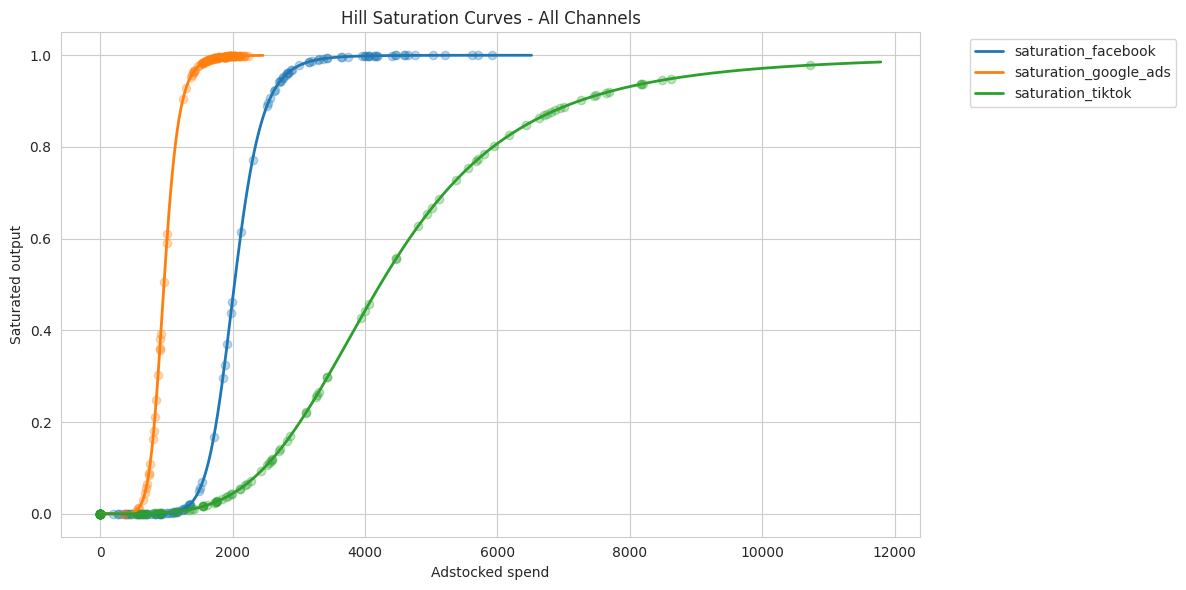

In [ ]:
# Corresponding alpha and gamma values from your table
saturation_best_params = dict(zip(sat_gpby['channel'], zip(sat_gpby['alpha'], sat_gpby['gamma'])))

plt.figure(figsize=(12, 6))

colors = plt.cm.tab10.colors  # 10 distinct colors

for i, col in enumerate(saturation_best_params.keys()):
    alpha, gamma = saturation_best_params[col]
    adstock_vals = X_train_saturation[col.replace('saturation', 'adstock')].values
    x_range = np.linspace(0, adstock_vals.max() * 1.1, 200)

    y_curve = safe_saturation(x_range, alpha if alpha>0 else 1e-6, gamma)  # avoid divide-by-zero

    plt.plot(x_range, y_curve, label=col, color=colors[i % 10], linewidth=2)
    plt.scatter(adstock_vals, safe_saturation(adstock_vals, alpha if alpha>0 else 1e-6, gamma),
                color=colors[i % 10], alpha=0.3)

plt.xlabel('Adstocked spend')
plt.ylabel('Saturated output')
plt.title('Hill Saturation Curves - All Channels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
consolidated_params = pd.merge(
      pd.DataFrame(adstock_best_params) \
      .transpose() \
      .reset_index() \
      .rename({'index': 'channel', 0: 'adstock_shape', 1: 'adstock_scale'}, axis=1).replace(to_replace=r'^adstock_', value='', regex=True),
      pd.DataFrame(saturation_best_params) \
      .transpose() \
      .reset_index() \
      .rename({'index': 'channel', 0: 'saturation_alpha', 1: 'saturation_gamma'}, axis=1).replace(to_replace=r'^saturation_', value='', regex=True)
    , on='channel')

In [ ]:
consolidated_params

,channel,adstock_shape,adstock_scale,saturation_alpha,saturation_gamma
0,facebook,0.5,0.9,2025.688083,9.6
1,google_ads,0.5,0.9,961.773700,8.6
2,tiktok,0.5,0.9,4228.194875,4.1


We'll deal with the presentation later. Onward to the MMM Model!


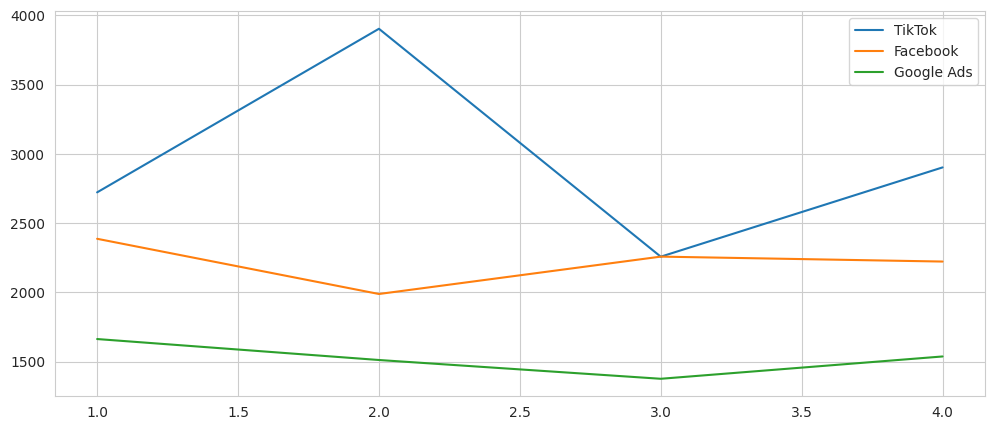

In [ ]:
quarterly_spend = df.copy()
quarterly_spend['quarter'] = quarterly_spend.index.quarter
quarterly_spend = quarterly_spend.groupby('quarter')[['tiktok', 'facebook', 'google_ads']].mean()

plt.figure(figsize=(12,5))
plt.plot(quarterly_spend.index, quarterly_spend['tiktok'], label='TikTok')
plt.plot(quarterly_spend.index, quarterly_spend['facebook'], label='Facebook')
plt.plot(quarterly_spend.index, quarterly_spend['google_ads'], label='Google Ads')
plt.legend()
plt.show()

# MMM Model

**Note: Refits done in existing cells.**

1. Removed trend, greatly improved R2, BIC, RMSE and MAPE.
2. Added monthly dummies, introduced multicollinearity. Removed them.
3. Though fourier yearly seasonality variables improved R2, Adj R2 and were significant, Out of Sample testing showed that the model's generalization abilities degraded.
4. Added fourier quarterly variables to check if seasonality is a confounding variable. Both variables not significant and adding more introduced strong multicollinearity in the model. Removing seasonality entirely. Otherwise, out of sample testing will not be a factor to understand budget optimization.

In [ ]:
def make_fourier_features(df, K, T, prefix):
    """
    Adds Fourier seasonal terms using a continuous time index t.

    df: DataFrame
    K: number of harmonic pairs (sin_k, cos_k)
    T: seasonal period (365 or 365.25 for yearly seasonality)
    """

    # Continuous time index starting at 0
    t = np.arange(len(df))

    # Generate Fourier terms
    for k in range(1, K + 1):
        df[f'{prefix}_sin_K{k}'] = np.sin(2 * np.pi * k * t / T)
        df[f'{prefix}_cos_K{k}'] = np.cos(2 * np.pi * k * t / T)

    return df

In [ ]:
# df.set_index('date', inplace=True)
y_final = df['sales']
X_final = df[['facebook', 'google_ads', 'tiktok']]

In [ ]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.4, shuffle=False)
X_test_final, X_val_final, y_test_final, y_val_final = train_test_split(X_test_final, y_test_final, test_size=0.5, shuffle=False)

In [ ]:
X_train_final.columns

Index(['facebook', 'google_ads', 'tiktok'], dtype='object')

In [ ]:
final_sat_cols = [col for col in X_train_final.columns if 'quarterly' not in col]
print(final_sat_cols)
for each in [X_train_final, X_test_final, X_val_final]:
  for col in final_sat_cols:
      cons_col = col.replace('saturation_', '')
      shape = consolidated_params.loc[consolidated_params['channel'] == cons_col, 'adstock_shape'].values[0]
      scale = consolidated_params.loc[consolidated_params['channel'] == cons_col, 'adstock_scale'].values[0]
      alpha = consolidated_params.loc[consolidated_params['channel'] == cons_col, 'saturation_alpha'].values[0]
      gamma = consolidated_params.loc[consolidated_params['channel'] == cons_col, 'saturation_gamma'].values[0]

      adstocked = adstock_weibull_safe(each[col], shape, scale)
      each[f'saturation_{col}'] = safe_saturation(adstocked, alpha, gamma)
      each.drop(col, axis=1, inplace=True)

['facebook', 'google_ads', 'tiktok']


In [ ]:
X_train_final_const = sm.add_constant(X_train_final)
model = OLS(y_train_final, X_train_final_const)
res = model.fit(cov_type='HAC', cov_kwds={'maxlags':52})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     523.1
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           3.25e-67
Time:                        07:08:12   Log-Likelihood:                -1000.6
No. Observations:                 120   AIC:                             2009.
Df Residuals:                     116   BIC:                             2020.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5802.3204    206.036     28.162      0.000    5398.497    6206.144
saturation_facebook    2682.0976    198.200     13.532      0.000    2293.633    3070.562
saturation_google_ads  2731.1476    195.821     13.947      0.000    2347.346    3114.950
saturation_tiktok      4981.2136    172.590     28.862      0.000    4642.943    5319.484
==============================================================================
Omnibus:                        2.016   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.365   Jarque-Bera (JB):                2.062
Skew:                           0.281   Prob(JB):                        0.357
Kurtosis:                       2.691   Cond. No.                         5.24
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 52 lags and without small sample correction
"""

In [ ]:
X_test_final_const = sm.add_constant(X_test_final)
y_pred_final_test = res.predict(X_test_final_const)

print(f'Calculating effect on Test')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_final_test))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_final, y_pred_final_test)}')
print(f'*'*80)

X_val_final_const = sm.add_constant(X_val_final)
y_pred_final_val = res.predict(X_val_final_const)

print(f'Calculating effect on Val')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val_final, y_pred_final_val))}')
print(f'MAPE: {mean_absolute_percentage_error(y_val_final, y_pred_final_val)}')

Calculating effect on Test
RMSE: 1201.887143101758
MAPE: 0.09464040001317438
********************************************************************************
Calculating effect on Val
RMSE: 868.8012357704544
MAPE: 0.06742862899592872


In [ ]:
coef_df = res.params.iloc[1:].reset_index().rename({'index':'channel', 0:'coefs'}, axis=1)
coef_df['channel'] = coef_df['channel'].str.replace('saturation_', '')
consolidated_params = consolidated_params.rename({'spend': 'channel'}, axis=1)
consolidated_params = consolidated_params.join(coef_df.set_index('channel'), on='channel')

In [ ]:
consolidated_params

,channel,adstock_shape,adstock_scale,saturation_alpha,saturation_gamma,coefs
0,facebook,0.5,0.9,2025.688083,9.6,2682.097555
1,google_ads,0.5,0.9,961.773700,8.6,2731.147646
2,tiktok,0.5,0.9,4228.194875,4.1,4981.213602


In [ ]:
model_results = pd.DataFrame({'y_test':y_test_final, 'y_pred_test':y_pred_final_test, 'y_val': y_val_final, 'y_pred_val': y_pred_final_val})
model_results.to_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/model_results.csv')

# Budget Optimization and Recommendations

In [ ]:
# Marginal saturation (derivative of Hill function)
def marginal_saturation(spend, alpha, gamma):
    numerator = gamma * (alpha**gamma) * (spend**(gamma-1))
    denominator = (alpha**gamma + spend**gamma)**2
    return numerator / denominator

In [ ]:
# Immediate adstock effects
for i, channel in enumerate(consolidated_params['channel']):
  shape = consolidated_params.loc[i, 'adstock_shape']
  scale = consolidated_params.loc[i, 'adstock_scale']
  consolidated_params.loc[i, 'immediate_effect'] = adstock_weibull_safe([1],shape,scale)

  print(f"{channel} immediate effect: {consolidated_params.loc[i,'immediate_effect']:.4f}")


# Calculating full marginal ROI
ref_calculation = {}

# Step 0. Get mean RAW spend
for i, channel in enumerate(consolidated_params['channel']):
  ref_calculation[f'raw_mean_{channel}'] = df[channel].mean() # Raw spend from original df

  # Adstock step
  shape = consolidated_params.loc[i, 'adstock_shape']
  scale = consolidated_params.loc[i, 'adstock_scale']
  ref_calculation[f'adstock_mean_{channel}'] = adstock_weibull_safe([ref_calculation[f'raw_mean_{channel}']], shape, scale)

  # Saturation step
  alpha = consolidated_params.loc[i, 'saturation_alpha']
  gamma = consolidated_params.loc[i, 'saturation_gamma']
  ref_calculation[f'marginal_saturation_{channel}'] = marginal_saturation(ref_calculation[f'adstock_mean_{channel}'], alpha, gamma)

  # Chain rule - marginal sales per RAW dollar
  ref_calculation[f'marginal_roi_{channel}'] = consolidated_params.loc[i,'coefs'] * ref_calculation[f'marginal_saturation_{channel}'] * consolidated_params.loc[i,'immediate_effect']

  print(f"Marginal ROI of {channel}:   {ref_calculation[f'marginal_roi_{channel}'][0]:.4f} sales per $1")

facebook immediate effect: 0.5387
google_ads immediate effect: 0.5387
tiktok immediate effect: 0.5387
Marginal ROI of facebook:   0.0710 sales per $1
Marginal ROI of google_ads:   2.4813 sales per $1
Marginal ROI of tiktok:   0.1204 sales per $1


In [ ]:
consolidated_params

,channel,adstock_shape,adstock_scale,saturation_alpha,saturation_gamma,coefs,immediate_effect
0,facebook,0.5,0.9,2025.688083,9.6,2682.097555,0.538713
1,google_ads,0.5,0.9,961.773700,8.6,2731.147646,0.538713
2,tiktok,0.5,0.9,4228.194875,4.1,4981.213602,0.538713


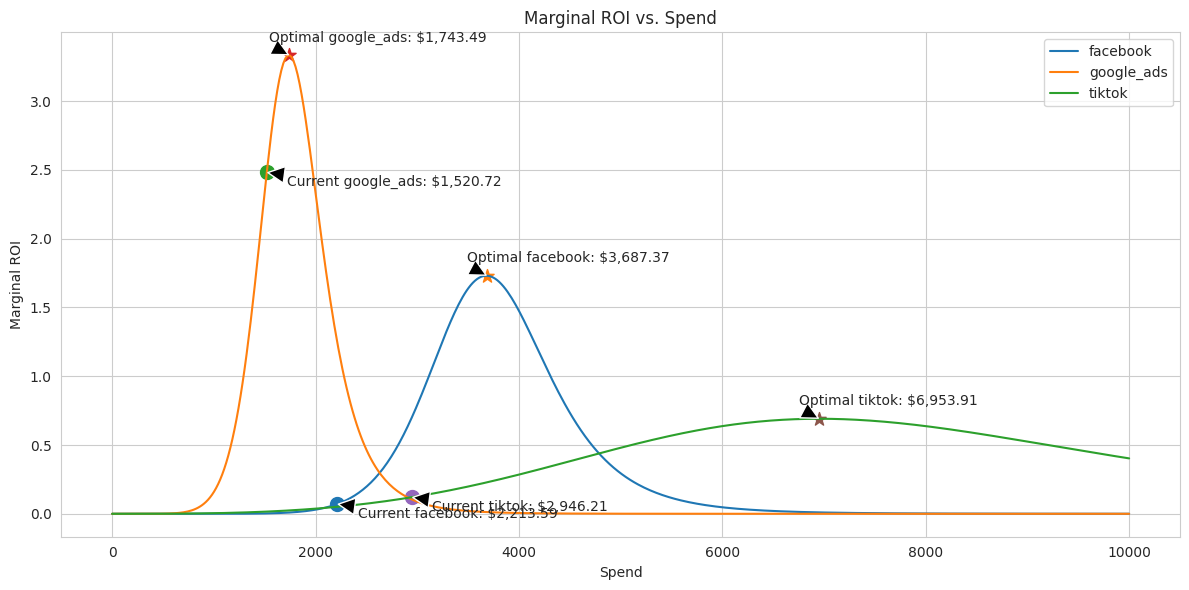

In [ ]:
plt.figure(figsize=(12,6))
# Create spend range
spend_range = np.linspace(0, 10000, 500)

channels = consolidated_params['channel']
# For each channel, calculate marginal ROI at different spend levels
for channel in channels:
  filt_df = consolidated_params.loc[consolidated_params['channel'] == channel]
  coef = filt_df['coefs'].values[0]
  immediate_effect = filt_df['immediate_effect'].values[0]
  shape = filt_df['adstock_shape'].values[0]
  scale = filt_df['adstock_scale'].values[0]
  alpha = filt_df['saturation_alpha'].values[0]
  gamma = filt_df['saturation_gamma'].values[0]
  marginal_sat_curve = [
      coef * marginal_saturation(adstock_weibull_safe([s], shape, scale), alpha, gamma)[0] * immediate_effect
      for s in spend_range
  ]
  # Optimal Values
  opt_val = max(marginal_sat_curve)
  opt_spend = spend_range[marginal_sat_curve.index(opt_val)]

  # Current Values
  cur_spend = df[channel.replace('saturation_','')].mean()
  cur_val = coef * marginal_saturation(adstock_weibull_safe([cur_spend], shape, scale), alpha, gamma)[0] * immediate_effect

  # Plot Sat Curve
  plt.plot(spend_range, marginal_sat_curve, label=channel)

  # Plot and annotate current spend
  plt.scatter(cur_spend, cur_val, marker='o', s=100)
  plt.annotate(f'Current {channel.replace('saturation_','')}: ${cur_spend:,.2f}', xy=(cur_spend, cur_val), xytext=(cur_spend+200, cur_val-0.1) ,arrowprops=dict(facecolor='black', shrink=0.05))

  # Plot Optimal values and annotate them
  plt.scatter(opt_spend, opt_val, marker='*', s=100)
  plt.annotate(f'Optimal {channel.replace('saturation_','')}: ${opt_spend:,.2f}', xy=(opt_spend, opt_val), xytext=(opt_spend-200, opt_val+0.1) ,arrowprops=dict(facecolor='black', shrink=0.05))


plt.xlabel('Spend')
plt.ylabel('Marginal ROI')
plt.title('Marginal ROI vs. Spend')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
consolidated_params.to_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/consolidated_params.csv', index=False)
df.to_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/forecastegy_mmm1_final.csv', index=False)

# Altair for Streamlit

In [9]:
consolidated_params = pd.read_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/consolidated_params.csv')
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/forecastegy_mmm1_final.csv')

In [7]:
# Marginal saturation (derivative of Hill function)
def marginal_saturation(spend, alpha, gamma):
    numerator = gamma * (alpha**gamma) * (spend**(gamma-1))
    denominator = (alpha**gamma + spend**gamma)**2
    return numerator / denominator

In [10]:
mROI_df = pd.DataFrame()

spend_range = np.linspace(0, 10000, 500) # Change based on available budget

for channel in consolidated_params['channel']:
  shape = consolidated_params.loc[consolidated_params['channel'] == channel, 'adstock_shape'].values[0]
  scale = consolidated_params.loc[consolidated_params['channel'] == channel, 'adstock_scale'].values[0]
  alpha = consolidated_params.loc[consolidated_params['channel'] == channel, 'saturation_alpha'].values[0]
  gamma = consolidated_params.loc[consolidated_params['channel'] == channel, 'saturation_gamma'].values[0]
  coef = consolidated_params.loc[consolidated_params['channel'] == channel, 'coefs'].values[0]
  immediate_effect = consolidated_params.loc[consolidated_params['channel'] == channel, 'immediate_effect'].values[0]

  mar_saturation = [marginal_saturation(adstock_weibull_safe([s], shape, scale), alpha, gamma)[0] for s in spend_range]
  mROI_df[channel] = list(coef * np.array(mar_saturation) * immediate_effect)
mROI_df['spend'] = spend_range

In [11]:
mROI_plotting = mROI_df.melt(
    id_vars=['spend'],
    var_name='channel',
    value_name='sat_curve_pts'
)

In [13]:
curr_point_df = consolidated_params.join(df.iloc[:,:3].mean().rename('spend'), on='channel').reset_index()

curr_point_df['sat_curve_pts'] = curr_point_df.apply(
      lambda x: x['coefs'] *
        marginal_saturation(
            adstock_weibull_safe([x['spend']], x['adstock_shape'], x['adstock_scale']
        ), x['saturation_alpha'], x['saturation_gamma'])[0] *\
        x['immediate_effect'], axis=1)

In [ ]:
curr_point_df.to_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/current_points.csv', index=False)
mROI_plotting.to_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/mROI_plotting.csv', index=False)

In [15]:
# 1. Slider

# Instantiate the slider
fb_slider = alt.binding_range(min=0, max=10000,step=100,name='Facebook Budget    ')
gg_slider = alt.binding_range(min=0, max=10000,step=100,name='Google Ads Budget    ')
tt_slider = alt.binding_range(min=0, max=10000,step=100,name='TikTok Budget    ')

# Param Value
fb_budget = alt.param(name='fb_budget',value=0, bind=fb_slider)
gg_budget = alt.param(name='gg_budget',value=0, bind=gg_slider)
tt_budget = alt.param(name='tt_budget',value=0, bind=tt_slider)

# 2. Base Layer
base_chart = alt.Chart(mROI_plotting).properties(
    width=800,
    height=400
).add_params(fb_budget, gg_budget, tt_budget)

# 3. Curve Layer
curves = base_chart.mark_line().encode(
  x = alt.X('spend', title='Marketing Spend'),
  y = alt.Y('sat_curve_pts', title='Marginal ROI'),
  color = 'channel'
)

# 4.1 Base Points
base_points = base_chart.encode(
    color='channel'
)

# 4.2 Optimal Points
opt_points = base_points.transform_window(
    max_sat='max(sat_curve_pts)',
    groupby=['channel'],
    frame=[None, None]
).mark_point(
    filled=True,
    shape='diamond',
    size=200
).encode(
    x='spend:Q',
    y='sat_curve_pts:Q',
    tooltip=[
      alt.Tooltip("channel", title='Channel'),
      alt.Tooltip("spend", title='Spend', format='$.2f'),
      alt.Tooltip("sat_curve_pts", title='Marginal ROI', format='$.2f')
    ]
).transform_filter(
    alt.datum.sat_curve_pts == alt.datum.max_sat
).transform_calculate(
    label_text='"Optimum " + datum.channel + " spend : " + format(datum.spend, "$,.2f")'
)

# Optimal Labels
opt_labels = opt_points.mark_text(
    align='left',
    dx=5,       # Shift the label 5 pixels to the right
    dy=-5
).encode(
    x='spend:Q',
    y='sat_curve_pts:Q',
    text='label_text:N',
    tooltip=[
      alt.Tooltip("channel", title='Channel'),
      alt.Tooltip("spend", title='Spend', format='$.2f'),
      alt.Tooltip("sat_curve_pts", title='Marginal ROI', format='$.2f')
    ]
)

# 4.3 Current Points
current_points = alt.Chart(curr_point_df).mark_point(
    filled=True,
    shape='diamond',
    size=200
).encode(
    x='spend',
    y='sat_curve_pts',
    color='channel:N',
    tooltip=[
      alt.Tooltip("channel", title='Channel'),
      alt.Tooltip("spend", title='Spend', format='$.2f'),
      alt.Tooltip("sat_curve_pts", title='Marginal ROI', format='$.2f')
    ]
).transform_calculate(
    label_text='"Current " + datum.channel + " spend : " + format(datum.spend, "$,.2f")'
)

# Current Labels
current_labels = current_points.mark_text(
    align='left',
    dx=-5,       # Shift the label 5 pixels to the right
    dy=-10
).encode(
    x='spend:Q',
    y='sat_curve_pts:Q',
    text='label_text:N'
)

# 5. Slider Integration
def make_slider_point(chart, channel, budget):
    return (
        chart
        .transform_filter(
            f"datum.channel == '{channel}'"
        )
        .transform_calculate(
            budget_value=f"{budget.name}",                    # param → field
            dist="abs(datum.spend - datum.budget_value)"     # use datum.budget_value
        )
        .transform_window(
            sort=[{"field": "dist", "order": "ascending"}],
            window=[{"op": "rank", "as": "rank"}]
        )
        .transform_filter("datum.rank == 1")
        .mark_point(
            filled=False,
            size=250,
                     # now works again
            strokeWidth=5
        )
        .encode(
            x="spend:Q",
            y="sat_curve_pts:Q",
            color="channel:N",
            tooltip=[
              alt.Tooltip("channel", title='Channel'),
              alt.Tooltip("spend", title='Spend', format='$.2f'),
              alt.Tooltip("sat_curve_pts", title='Marginal ROI', format='$.2f')
            ]
        )
    )

fb_point = make_slider_point(base_chart, 'facebook', fb_budget)
gg_point = make_slider_point(base_chart, 'google_ads', gg_budget)
tt_point = make_slider_point(base_chart, 'tiktok', tt_budget)


In [16]:
# Don't forget to call the created items!!!
chart = curves + opt_points + opt_labels + current_points + current_labels + fb_point + gg_point + tt_point
chart

alt.LayerChart(...)

In [ ]:
model_results = pd.read_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/model_results.csv')

In [ ]:
mod_chart_test = alt.Chart(model_results.melt(id_vars=['date'], value_vars=['y_test','y_pred_test']).dropna()).encode(
    x='date',
    y='value',
    color='variable'
).mark_line()

mod_chart_test

alt.Chart(...)

In [ ]:
mod_chart_val = alt.Chart(model_results.melt(id_vars=['date'], value_vars=['y_val', 'y_pred_val']).dropna()).encode(
    x='date',
    y='value',
    color='variable'
).mark_line()

mod_chart_val

alt.Chart(...)

In [ ]:
df.head()

,tiktok,facebook,google_ads,sales
0,13528.1,0.00,0.00,9779.80
1,0.0,5349.65,2218.93,13245.19
2,0.0,4235.86,2046.96,12022.66
3,0.0,3562.21,0.00,8846.95
4,0.0,0.00,2187.29,9797.07


In [ ]:
consolidated_params.head()

,channel,adstock_shape,adstock_scale,saturation_alpha,saturation_gamma,coefs,immediate_effect
0,facebook,0.5,0.9,2025.688083,9.6,2682.097555,0.538713
1,google_ads,0.5,0.9,961.773700,8.6,2731.147646,0.538713
2,tiktok,0.5,0.9,4228.194875,4.1,4981.213602,0.538713


In [1]:
plot_sat_df = pd.DataFrame()

for i, channel in enumerate(consolidated_params['channel']):
  shape = consolidated_params.loc[i, 'adstock_shape']
  scale = consolidated_params.loc[i, 'adstock_scale']
  alpha = consolidated_params.loc[i, 'saturation_alpha']
  gamma = consolidated_params.loc[i, 'saturation_gamma']
  coef = consolidated_params.loc[i, 'coefs']

  temp = {}

  temp['channel'] = channel
  temp['adstock'] = adstock_weibull_safe(df[channel], shape, scale)
  temp['saturation'] = safe_saturation(temp['adstock'], alpha, gamma)


  plot_sat_df = pd.concat([plot_sat_df, pd.DataFrame(temp)])


NameError: name 'pd' is not defined

In [ ]:
plot_sat_df

,channel,saturation,spend
0,facebook,1.139996e-147,0.00
1,facebook,9.672156e-01,5349.65
2,facebook,9.904815e-01,4235.86
3,facebook,9.923652e-01,3562.21
4,facebook,1.205863e-01,0.00
...,...,...,...
195,tiktok,1.915796e-02,0.00
196,tiktok,8.806196e-01,11543.58
197,tiktok,1.316172e-01,0.00
198,tiktok,1.066342e-02,0.00


In [ ]:
plot_sat_df.to_csv('/content/drive/MyDrive/Data Analysis/datasets/forecastegy/output/plot_sat_df.csv', index=False)

In [ ]:
alt.Chart(plot_sat_df).encode(
    x='spend',
    y='saturation',
    color='channel'
).mark_line(
)

alt.Chart(...)